In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import torch

from models.light_gcn import LightGCNStack
from utils.light_gcn_utils import bpr_loss, evaluate, build_user_item_interactions, get_positive_negative_ratings, recall_at_k, precision_at_k

/home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZNSt15__exception_ptr13exception_ptr9_M_addrefEv
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.preprocess import load_dataset

# Load the dataset
dataset = 'movielens-1m'
users, items, train_ratings, test_ratings, items_features_tensor, user_features_tensor = load_dataset(dataset)

In [3]:
num_users = users['userid'].nunique()
num_items = items['itemid'].nunique()
print(f"num_users: {num_users}, num_items: {num_items}")

num_users: 6040, num_items: 3883


In [4]:
# Create edge index for bipartite graph for train set
train_user_ids = train_ratings['userid'].values
train_item_ids = train_ratings['itemid'].values + num_users 
train_edge_index = torch.tensor([train_user_ids, train_item_ids], dtype=torch.long)

# Create edge index for bipartite graph for test set
test_user_ids = test_ratings['userid'].values  
test_item_ids = test_ratings['itemid'].values + num_users  
test_edge_index = torch.tensor([test_user_ids, test_item_ids], dtype=torch.long)

/tmp/ipykernel_43853/1560685500.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_edge_index = torch.tensor([train_user_ids, train_item_ids], dtype=torch.long)


In [5]:
train_user_item_dict = build_user_item_interactions(train_ratings)
test_user_item_dict = build_user_item_interactions(test_ratings)

In [6]:
positive_threshold = 5
negative_threshold = 4

In [7]:
train_user_ratings = get_positive_negative_ratings(train_user_item_dict, positive_threshold, negative_threshold)
test_user_ratings = get_positive_negative_ratings(test_user_item_dict, positive_threshold, negative_threshold)

In [8]:
for i, user in enumerate(train_user_ratings):
    train_user_ratings[i] = (user[0], [item + num_users for item in user[1]], [item + num_users for item in user[2]])

for i, user in enumerate(test_user_ratings):
    test_user_ratings[i] = (user[0], [item + num_users for item in user[1]], [item + num_users for item in user[2]])

In [9]:
embedding_dim = 384
num_nodes = num_users + num_items
no_user_features = user_features_tensor.size(1)
no_item_features = items_features_tensor.size(1)

num_layers = 10
num_epochs = 50
learning_rate = 0.0005
k = 10

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

user_features_tensor = user_features_tensor.to(device)
items_features_tensor = items_features_tensor.to(device)
train_edge_index = train_edge_index.to(device)
test_edge_index = test_edge_index.to(device)

model = LightGCNStack(num_nodes, no_user_features, no_item_features, embedding_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
embeddings = model(user_features_tensor, items_features_tensor, train_edge_index)
recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)

print("Base recall:", recall)
print("Base precision:", precision)

Base recall: 0.1527898141239013
Base precision: 0.3146273791687464


In [12]:
calc_metrics_every = 1
losses = []
recalls = []
precisions = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    pbar = tqdm(train_user_ratings, desc=f'Epoch {epoch+1}/{num_epochs}')
    embeddings = model(user_features_tensor, items_features_tensor, train_edge_index)

    for user_id, pos_items, neg_items in pbar:
        no_sample = min(len(pos_items), len(neg_items))
        users = torch.tensor([user_id] * no_sample, dtype=torch.long).to(device)
        pos_samples = random.sample(pos_items, no_sample)
        pos_samples = torch.tensor(pos_samples, dtype=torch.long).to(device)
        neg_samples = random.sample(neg_items, no_sample)
        neg_samples = torch.tensor(neg_samples, dtype=torch.long).to(device)
        
        loss = bpr_loss(embeddings, users, pos_samples, neg_samples)
        total_loss += loss
        num_batches += 1
        avg_loss = total_loss.item() / num_batches

        pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})

    total_loss.backward()
    optimizer.step()

    losses.append(total_loss)
    
    if (epoch + 1) % calc_metrics_every == 0:
        recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
        precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)
        recalls.append(recall)
        precisions.append(precision)
        avg_loss = total_loss / len(train_user_ratings)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Recall@{k}: {recall:.4f}, Precision@{k}: {precision:.4f}')
    else:
        avg_loss = total_loss / len(train_user_ratings)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    

Epoch 1/50: 100%|██████████| 6007/6007 [00:10<00:00, 572.49it/s, Avg Loss=0.6928]


Epoch 1/50, Loss: 0.6928, Recall@10: 0.1528, Precision@10: 0.3146


Epoch 2/50: 100%|██████████| 6007/6007 [00:09<00:00, 663.96it/s, Avg Loss=0.6894]


Epoch 2/50, Loss: 0.6894, Recall@10: 0.1975, Precision@10: 0.4280


Epoch 3/50: 100%|██████████| 6007/6007 [00:12<00:00, 499.60it/s, Avg Loss=0.6865]


Epoch 3/50, Loss: 0.6865, Recall@10: 0.1963, Precision@10: 0.4330


Epoch 4/50: 100%|██████████| 6007/6007 [00:12<00:00, 481.15it/s, Avg Loss=0.6839]


Epoch 4/50, Loss: 0.6839, Recall@10: 0.1975, Precision@10: 0.4344


Epoch 5/50: 100%|██████████| 6007/6007 [00:13<00:00, 431.58it/s, Avg Loss=0.6819]


Epoch 5/50, Loss: 0.6819, Recall@10: 0.1999, Precision@10: 0.4352


Epoch 6/50: 100%|██████████| 6007/6007 [00:12<00:00, 486.19it/s, Avg Loss=0.6800]


Epoch 6/50, Loss: 0.6800, Recall@10: 0.2002, Precision@10: 0.4355


Epoch 7/50: 100%|██████████| 6007/6007 [00:12<00:00, 477.93it/s, Avg Loss=0.6786]


Epoch 7/50, Loss: 0.6786, Recall@10: 0.1988, Precision@10: 0.4312


Epoch 8/50: 100%|██████████| 6007/6007 [00:08<00:00, 733.31it/s, Avg Loss=0.6783]


Epoch 8/50, Loss: 0.6783, Recall@10: 0.1978, Precision@10: 0.4296


Epoch 9/50: 100%|██████████| 6007/6007 [00:08<00:00, 721.23it/s, Avg Loss=0.6772]


Epoch 9/50, Loss: 0.6772, Recall@10: 0.1945, Precision@10: 0.4235


Epoch 10/50: 100%|██████████| 6007/6007 [00:08<00:00, 727.56it/s, Avg Loss=0.6781]


Epoch 10/50, Loss: 0.6781, Recall@10: 0.1976, Precision@10: 0.4229


Epoch 11/50: 100%|██████████| 6007/6007 [00:08<00:00, 687.63it/s, Avg Loss=0.6779]


Epoch 11/50, Loss: 0.6779, Recall@10: 0.1971, Precision@10: 0.4207


Epoch 12/50: 100%|██████████| 6007/6007 [00:08<00:00, 681.12it/s, Avg Loss=0.6770]


Epoch 12/50, Loss: 0.6770, Recall@10: 0.1933, Precision@10: 0.4131


Epoch 13/50: 100%|██████████| 6007/6007 [00:09<00:00, 646.79it/s, Avg Loss=0.6784]


Epoch 13/50, Loss: 0.6784, Recall@10: 0.1945, Precision@10: 0.4095


Epoch 14/50: 100%|██████████| 6007/6007 [00:08<00:00, 691.68it/s, Avg Loss=0.6781]


Epoch 14/50, Loss: 0.6781, Recall@10: 0.1962, Precision@10: 0.4075


Epoch 15/50: 100%|██████████| 6007/6007 [00:09<00:00, 651.39it/s, Avg Loss=0.6757]


Epoch 15/50, Loss: 0.6757, Recall@10: 0.1934, Precision@10: 0.4008


Epoch 16/50: 100%|██████████| 6007/6007 [00:08<00:00, 667.97it/s, Avg Loss=0.6751]


Epoch 16/50, Loss: 0.6751, Recall@10: 0.1913, Precision@10: 0.3946


Epoch 17/50: 100%|██████████| 6007/6007 [00:08<00:00, 700.91it/s, Avg Loss=0.6733]


Epoch 17/50, Loss: 0.6733, Recall@10: 0.1896, Precision@10: 0.3896


Epoch 18/50: 100%|██████████| 6007/6007 [00:08<00:00, 686.08it/s, Avg Loss=0.6724]


Epoch 18/50, Loss: 0.6724, Recall@10: 0.1870, Precision@10: 0.3858


Epoch 19/50: 100%|██████████| 6007/6007 [00:07<00:00, 818.10it/s, Avg Loss=0.6715]


Epoch 19/50, Loss: 0.6715, Recall@10: 0.1857, Precision@10: 0.3830


Epoch 20/50: 100%|██████████| 6007/6007 [00:07<00:00, 847.09it/s, Avg Loss=0.6734]


Epoch 20/50, Loss: 0.6734, Recall@10: 0.1844, Precision@10: 0.3807


Epoch 21/50: 100%|██████████| 6007/6007 [00:07<00:00, 844.36it/s, Avg Loss=0.6751]


Epoch 21/50, Loss: 0.6751, Recall@10: 0.1830, Precision@10: 0.3756


Epoch 22/50: 100%|██████████| 6007/6007 [00:07<00:00, 814.50it/s, Avg Loss=0.6814]


Epoch 22/50, Loss: 0.6814, Recall@10: 0.1805, Precision@10: 0.3701


Epoch 23/50: 100%|██████████| 6007/6007 [00:08<00:00, 730.74it/s, Avg Loss=0.6871]


Epoch 23/50, Loss: 0.6871, Recall@10: 0.1763, Precision@10: 0.3607


Epoch 24/50: 100%|██████████| 6007/6007 [00:08<00:00, 728.19it/s, Avg Loss=0.6951]


Epoch 24/50, Loss: 0.6951, Recall@10: 0.1728, Precision@10: 0.3533


Epoch 25/50: 100%|██████████| 6007/6007 [00:09<00:00, 610.87it/s, Avg Loss=0.7030]


Epoch 25/50, Loss: 0.7030, Recall@10: 0.1665, Precision@10: 0.3443


Epoch 26/50: 100%|██████████| 6007/6007 [00:10<00:00, 557.27it/s, Avg Loss=0.7073]


Epoch 26/50, Loss: 0.7073, Recall@10: 0.1645, Precision@10: 0.3418


Epoch 27/50: 100%|██████████| 6007/6007 [00:09<00:00, 622.58it/s, Avg Loss=0.7077]


Epoch 27/50, Loss: 0.7077, Recall@10: 0.1640, Precision@10: 0.3421


Epoch 28/50: 100%|██████████| 6007/6007 [00:09<00:00, 636.05it/s, Avg Loss=0.7051]


Epoch 28/50, Loss: 0.7051, Recall@10: 0.1642, Precision@10: 0.3456


Epoch 29/50: 100%|██████████| 6007/6007 [00:09<00:00, 615.19it/s, Avg Loss=0.7010]


Epoch 29/50, Loss: 0.7010, Recall@10: 0.1668, Precision@10: 0.3513


Epoch 30/50: 100%|██████████| 6007/6007 [00:08<00:00, 687.71it/s, Avg Loss=0.6942]


Epoch 30/50, Loss: 0.6942, Recall@10: 0.1689, Precision@10: 0.3567


Epoch 31/50: 100%|██████████| 6007/6007 [00:07<00:00, 764.77it/s, Avg Loss=0.6870]


Epoch 31/50, Loss: 0.6870, Recall@10: 0.1729, Precision@10: 0.3641


Epoch 32/50: 100%|██████████| 6007/6007 [00:08<00:00, 704.52it/s, Avg Loss=0.6805]


Epoch 32/50, Loss: 0.6805, Recall@10: 0.1742, Precision@10: 0.3685


Epoch 33/50: 100%|██████████| 6007/6007 [00:07<00:00, 807.57it/s, Avg Loss=0.6744]


Epoch 33/50, Loss: 0.6744, Recall@10: 0.1821, Precision@10: 0.3802


Epoch 34/50: 100%|██████████| 6007/6007 [00:07<00:00, 805.42it/s, Avg Loss=0.6710]


Epoch 34/50, Loss: 0.6710, Recall@10: 0.1890, Precision@10: 0.3949


Epoch 35/50: 100%|██████████| 6007/6007 [00:07<00:00, 833.10it/s, Avg Loss=0.6707]


Epoch 35/50, Loss: 0.6707, Recall@10: 0.1944, Precision@10: 0.4053


Epoch 36/50: 100%|██████████| 6007/6007 [00:08<00:00, 720.49it/s, Avg Loss=0.6730]


Epoch 36/50, Loss: 0.6730, Recall@10: 0.1968, Precision@10: 0.4138


Epoch 37/50: 100%|██████████| 6007/6007 [00:07<00:00, 830.28it/s, Avg Loss=0.6792]


Epoch 37/50, Loss: 0.6792, Recall@10: 0.2008, Precision@10: 0.4266


Epoch 38/50: 100%|██████████| 6007/6007 [00:08<00:00, 733.23it/s, Avg Loss=0.6880]


Epoch 38/50, Loss: 0.6880, Recall@10: 0.2015, Precision@10: 0.4341


Epoch 39/50: 100%|██████████| 6007/6007 [00:08<00:00, 733.89it/s, Avg Loss=0.6976]


Epoch 39/50, Loss: 0.6976, Recall@10: 0.2035, Precision@10: 0.4401


Epoch 40/50: 100%|██████████| 6007/6007 [00:07<00:00, 799.47it/s, Avg Loss=0.7114]


Epoch 40/50, Loss: 0.7114, Recall@10: 0.2016, Precision@10: 0.4384


Epoch 41/50: 100%|██████████| 6007/6007 [00:11<00:00, 545.75it/s, Avg Loss=0.7248]


Epoch 41/50, Loss: 0.7248, Recall@10: 0.2015, Precision@10: 0.4383


Epoch 42/50: 100%|██████████| 6007/6007 [00:08<00:00, 745.09it/s, Avg Loss=0.7347]


Epoch 42/50, Loss: 0.7347, Recall@10: 0.1991, Precision@10: 0.4344


Epoch 43/50: 100%|██████████| 6007/6007 [00:07<00:00, 807.01it/s, Avg Loss=0.7436]


Epoch 43/50, Loss: 0.7436, Recall@10: 0.1983, Precision@10: 0.4298


Epoch 44/50: 100%|██████████| 6007/6007 [00:09<00:00, 644.13it/s, Avg Loss=0.7462]


Epoch 44/50, Loss: 0.7462, Recall@10: 0.2012, Precision@10: 0.4276


Epoch 45/50: 100%|██████████| 6007/6007 [00:11<00:00, 536.66it/s, Avg Loss=0.7486]


Epoch 45/50, Loss: 0.7486, Recall@10: 0.1997, Precision@10: 0.4232


Epoch 46/50: 100%|██████████| 6007/6007 [00:10<00:00, 591.29it/s, Avg Loss=0.7415]


Epoch 46/50, Loss: 0.7415, Recall@10: 0.2001, Precision@10: 0.4225


Epoch 47/50: 100%|██████████| 6007/6007 [00:08<00:00, 687.41it/s, Avg Loss=0.7345]


Epoch 47/50, Loss: 0.7345, Recall@10: 0.1950, Precision@10: 0.4096


Epoch 48/50: 100%|██████████| 6007/6007 [00:07<00:00, 771.03it/s, Avg Loss=0.7183]


Epoch 48/50, Loss: 0.7183, Recall@10: 0.1965, Precision@10: 0.4056


Epoch 49/50: 100%|██████████| 6007/6007 [00:09<00:00, 633.56it/s, Avg Loss=0.7060]


Epoch 49/50, Loss: 0.7060, Recall@10: 0.1928, Precision@10: 0.3973


Epoch 50/50: 100%|██████████| 6007/6007 [00:08<00:00, 735.93it/s, Avg Loss=0.6934]


Epoch 50/50, Loss: 0.6934, Recall@10: 0.1905, Precision@10: 0.3930


In [14]:
losses = [loss.item() for loss in losses]
recalls = [recall.item() for recall in recalls]
precisions = [precision.item() for precision in precisions]

AttributeError: 'float' object has no attribute 'item'

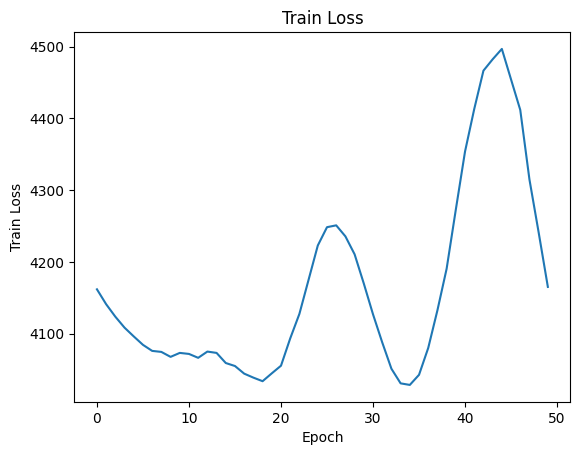

In [18]:
# make plots
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')
plt.show()

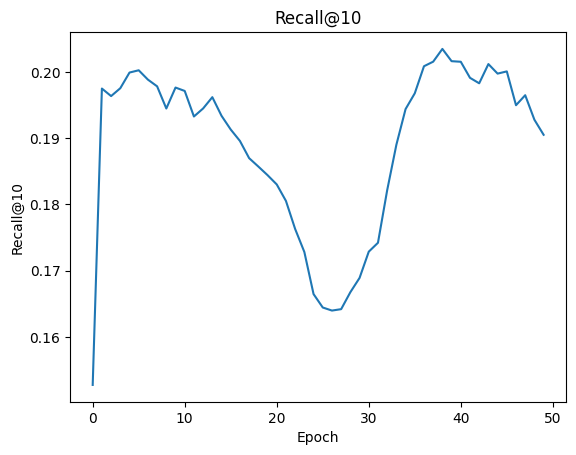

In [16]:
# Recall
plt.plot(recalls)
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.title('Recall@10')
plt.show()

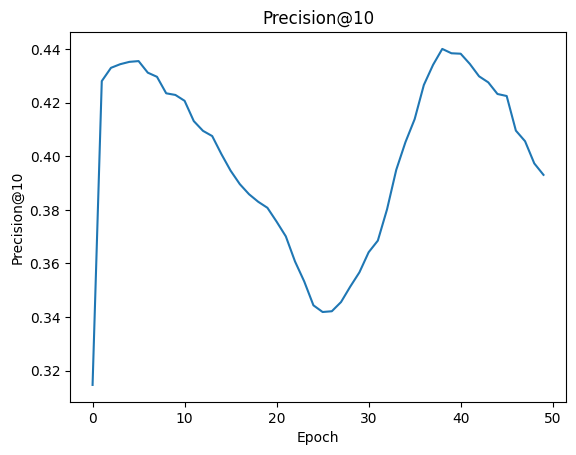

In [17]:
# Precision
plt.plot(precisions)
plt.xlabel('Epoch')
plt.ylabel('Precision@10')
plt.title('Precision@10')
plt.show()

In [ ]:
total_loss = 0
num_batches = 0
pbar = tqdm(test_user_ratings)

embeddings = model(user_features_tensor, items_features_tensor, test_edge_index)

for user_id, pos_items, neg_items in pbar:
    no_sample = min(len(pos_items), len(neg_items))
    users = torch.tensor([user_id] * no_sample, dtype=torch.long).to(device)
    pos_samples = random.sample(pos_items, no_sample)
    pos_samples = torch.tensor(pos_samples, dtype=torch.long).to(device)
    neg_samples = random.sample(neg_items, no_sample)
    neg_samples = torch.tensor(neg_samples, dtype=torch.long).to(device)
    loss = bpr_loss(embeddings, users, pos_samples, neg_samples)
    total_loss += loss
    num_batches += 1
    avg_loss = total_loss / num_batches

    # Update progress bar with average loss
    pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})
    
recall = recall_at_k(train_user_ratings, embeddings, k=k, device=device)
precision = precision_at_k(train_user_ratings, embeddings, k=k, device=device)
avg_loss = total_loss / len(test_user_ratings)
print(f'Test Loss: {avg_loss:.4f}, Test Recall@{k}: {recall:.4f}, Test Precision@{k}: {precision:.4f}')

100%|██████████| 5539/5539 [00:06<00:00, 918.95it/s, Avg Loss=0.7661]


Test Loss: 0.7661, Test Recall@10: 0.1706, Test Precision@10: 0.5294


In [ ]:
precision = [0.2623, 0.2616, 0.2618, 0.2619, 0.2615, 0.2617, 0.2616, 0.2618, 0.2622, 0.2612]
recall= [0.7758, 0.7744, 0.7739, 0.7748, 0.7742, 0.7735, 0.7742, 0.7740, 0.7758, 0.7725]
loss = [0.38828298449516296, 0.2226588875055313, 0.3194698691368103, 0.31795328855514526, 0.1744556874036789, 0.1744556874036789, 0.22327680885791779, 0.22724725306034088, 0.2899876832962036, 0.23551440238952637]

In [19]:
# goodbooks
precision = [0.3617, 0.3615, 0.3619, 0.3622, 0.3625, 0.3622, 0.3623, 0.3624, 0.3623, 0.3624]
recall = [0.9837, 0.9833, 0.9855, 0.9859, 0.9861, 0.9852, 0.9865, 0.9873, 0.9873, 0.9876]
loss = [0.4626704752445221, 0.4318108558654785, 0.4400472640991211, 0.37796998023986816, 0.38555628061294556, 0.38528645038604736, 0.3758946359157562, 0.3738066554069519, 0.3658704459667206, 0.38096436858177185]

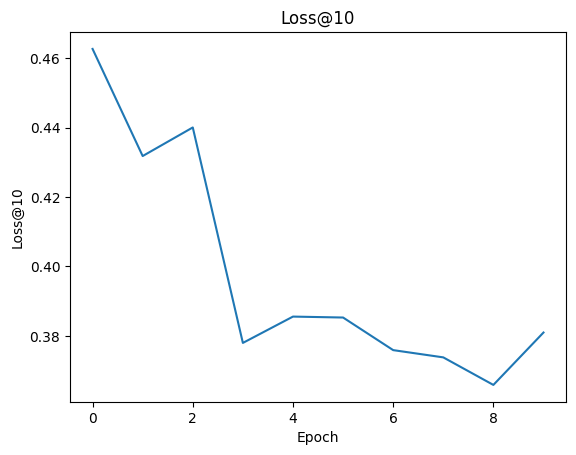

In [20]:
# Precision
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss@10')
plt.title('Loss@10')
plt.show()